In [9]:
import motionmapperpy as mmpy
from scipy.signal import cwt, ricker
import wavelet as wl
from src.data_factory.processing import *
from src.utils import *
from src.config import BLOCK, ROOT_LOCAL
from src.metrics.tank_area_config import *
%matplotlib inline
import matplotlib.pyplot as plt
parameters = mmpy.setRunParameters()
parameters.pcaModes = 3
parameters.samplingFreq = 5
parameters.maxF = 2.5
parameters.minF = 0.01
parameters.omega0 = 5
parameters.projectPath = projectPath
parameters.training_points_of_day = 200
parameters.numProcessors = 8
parameters.methode = "UMAP"
parameters.endident = f'{BLOCK}_*.npy'
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
parameters.useGPU=0
import cupy as cp
x = cp.array([1, 2, 3])
print(x.device)

<CUDA Device 0>


In [11]:
# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.
os.makedirs(parameters.projectPath,exist_ok=True)
mmpy.createProjectDirectory(parameters.projectPath)

Skipping, path already exists : content/Fish_moves
Skipping, path already exists : content/Fish_moves/Projections
Skipping, path already exists : content/Fish_moves/TSNE_Projections
Skipping, path already exists : content/Fish_moves/TSNE
Skipping, path already exists : content/Fish_moves/UMAP


In [12]:
fish_keys = get_camera_pos_keys()
area_f = get_area_functions()
days = get_all_days_of_context()
fk = fish_keys[1]
day = days[6]
area_t = (fk, area_f(fk,day))

#X = compute_projections(fk, day, area_t)
#X.shape

In [ ]:
sampleX = subsample_train_dataset(parameters, fish_keys[2:4])

In [7]:
sample_wlets = np.concatenate([s[2] for s in sampleX])

In [8]:
sample_wlets.shape

(11200, 75)

Text(0.5, 0, 'Frames')

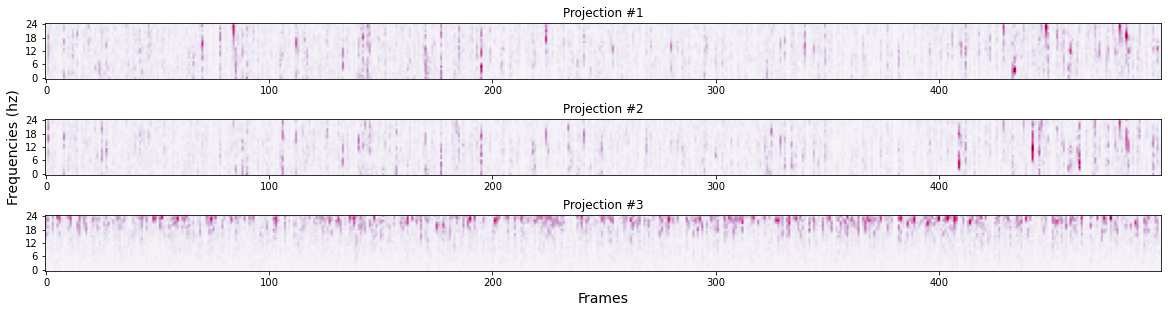

In [18]:
fig, axes = plt.subplots(parameters.pcaModes, 1, figsize=(20,5))

for i, ax in enumerate(axes.flatten()):
    nper = parameters.numPeriods
    ax.imshow(sample_wlets[:500,nper*i:nper*(i+1)].T.get(), cmap='PuRd', origin='lower')
    yticks = range(0, nper, 6)
    ax.set_yticks(yticks)
    #ax.set_yticklabels(['%0.1f'%freqs[j] for j in yticks])
    if i == parameters.pcaModes//2:
        ax.set_ylabel("Frequencies (hz)", fontsize=14)
    ax.set_title('Projection #%i'%(i+1))
ax.set_xlabel('Frames', fontsize=14)


In [11]:
X_em = mmpy.run_UMAP(sample_wlets.get(),parameters)

Saving UMAP model to disk...


In [65]:
# Loading training embedding
with h5py.File(tfolder+ 'training_embedding.mat', 'w') as hfile:
    hfile. 'trainingEmbedding'][:] = X_em
hdf5storage.write(data={'trainingEmbedding': X_em}, path='/', truncate_existing=True,
                      filename=tfolder + '/training_embedding.mat', store_python_metadata=False,
                      matlab_compatible=True)

KeyError: "Unable to open object (object 'trainingEmbedding' doesn't exist)"

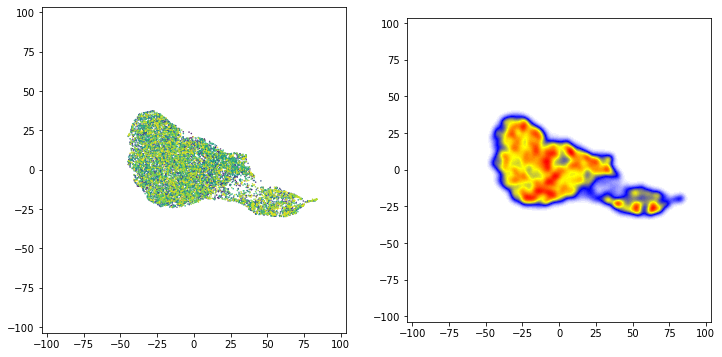

In [16]:
trainy = X_em
m = np.abs(trainy).max()
sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-20, m+20])

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=np.arange(trainy.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])
axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

In [26]:
#mmpy.wshed.findWatershedRegions(parameters, minimum_regions=7, endident=f"{BLOCK}*.npy")

In [17]:
parameters.method="UMAP"

In [34]:
#tsne takes 19 mins
import time
import h5py, hdf5storage, pickle, glob
tall = time.time()

tfolder = parameters.projectPath+'/%s/'%parameters.method

# Loading training data
trainingSetData = sample_wlets
trainingSetData[trainingSetData==0] = 1e-12

# Loading training embedding
trainingEmbedding= X_em

if parameters.method == 'TSNE':
    zValstr = 'zVals' 
else:
    zValstr = 'uVals'

projectionFiles = glob.glob(parameters.projectPath+f'/Projections/{BLOCK}*.npy')[:2]
for i in range(len(projectionFiles)):
    print('Finding Embeddings')
    t1 = time.time()
    print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))

    # Skip if embeddings already found.
    if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
        print('Already done. Skipping.\n')
        continue

    # load projections for a dataset
    projections = np.load(projectionFiles[i])[:,1:]

    # Find Embeddings
    zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)

    embedding_files=projectionFiles[i][:-4]
    print(embedding_files)
    # Save embeddings
    hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                    filename = embedding_files+'_%s.mat'%(zValstr), store_python_metadata = False,
                      matlab_compatible = True)
    
    # Save output statistics
    with open(embedding_files + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
        pickle.dump(outputStatistics, hfile)

    del zValues,projections,outputStatistics

print('All Embeddings Saved in %i seconds!'%(time.time()-tall))


Finding Embeddings
1/2 : content/Fish_moves/Projections/block1_23484204_back_20210911_060000.npy
Already done. Skipping.

Finding Embeddings
2/2 : content/Fish_moves/Projections/block1_23484204_back_20210912_060000.npy
Already done. Skipping.

All Embeddings Saved in 0 seconds!


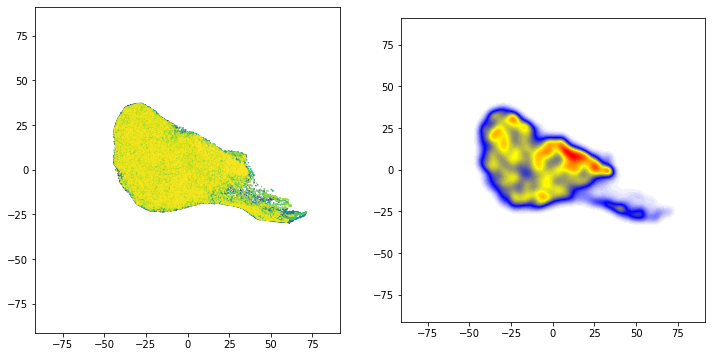

In [28]:
# load all the embeddings
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    ally = hdf5storage.loadmat(i)['zValues']

m = np.abs(ally).max()

sigma=2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(ally[:,0], ally[:,1], marker='.', c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

1/2 Loading embedding for block1_23484204_back_20210911_060000 0.00 seconds.
2/2 Loading embedding for block1_23484204_back_20210912_060000 0.04 seconds.
Starting watershed transform...
Assigning watershed regions...
	 tempsave done.
All data saved in UMAP/zVals_wShed_groups.mat.


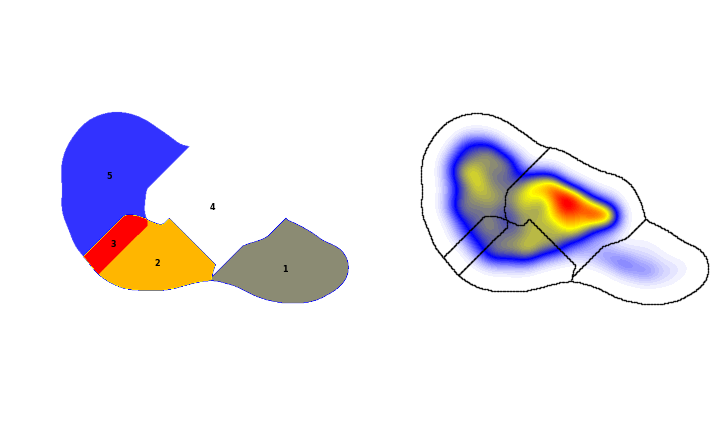

In [43]:
startsigma = 4.2 if parameters.method == 'TSNE' else 1.0
mmpy.findWatershedRegions(parameters, minimum_regions=5, startsigma=4, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = f'{BLOCK}_*.npy')

from IPython.display import Image
Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

In [60]:
wshedfile['watershedRegions'].shape

(1, 287213)

(20000, 6)
(20000, 6)


Text(0.5, 0, 'Time (min)')

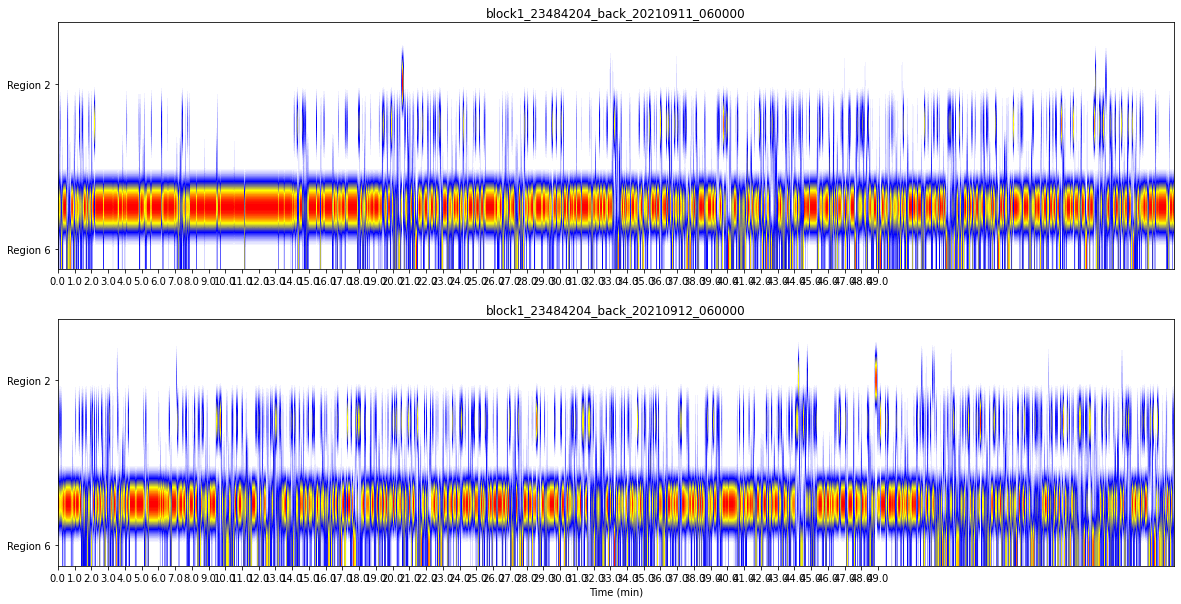

In [64]:
wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

wregs = wshedfile['watershedRegions'].flatten()[:40000]
ethogram = np.zeros((wregs.max()+1, len(wregs)))

for wreg in range(1, wregs.max()+1):
    ethogram[wreg, np.where(wregs==wreg)[0]] = 1.0


ethogram = np.split(ethogram.T, np.cumsum(
    #wshedfile['zValLens'][0].flatten()
[20000,20000])[:-1])

fig, axes = plt.subplots(2, 1, figsize=(20,10))

for e, name, ax in zip(ethogram, wshedfile['zValNames'][0], axes.flatten()):
    print(e.shape)
    ax.imshow(e.T, aspect='auto', cmap=mmpy.gencmap())
    ax.set_title(name[0][0])
    ax.set_yticks([i for i in range(1, wregs.max()+1, 4)])
    ax.set_yticklabels(['Region %i'%(j+1) for j in range(1, wregs.max()+1, 4)])

    xticklocs = [60*5*i for i in range(50)]
    ax.set_xticks(xticklocs)
    ax.set_xticklabels([j/(60*5) for j in xticklocs])

ax.set_xlabel('Time (min)')